General Imports

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt



## NLP and Embedding Imports, word2vec download (faster locally)

In [147]:
import gensim.downloader as api
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
nltk.download('punkt')


wv = api.load('word2vec-google-news-300')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cowan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## NLP Functions (from Lecture Notes)

In [263]:
def find_cosine(vec1, vec2):  # Scale vectors to both have unit length
  unit_vec1 = vec1/np.linalg.norm(vec1)
  unit_vec2 = vec2/np.linalg.norm(vec2)
  # The dot product of unit vectors gives the cosine of their angle
  return np.dot(unit_vec1,unit_vec2)


def find_avg_vector(txt, embedding):
  words = word_tokenize(txt)
  vec_sum = None
  count = 0
  for word in words:
    if word in embedding:
      count += 1
      if vec_sum is not None:
        vec_sum += embedding[word]
      else:
        # The embeddings are read-only unless you copy them
        vec_sum = embedding[word].copy()
  if vec_sum is None:
    return pd.Series(np.zeros((300,)))  # Treat no word found in embedding as zero vector
  return pd.Series(vec_sum/count)




## Loading data and adding the attractiveness data with regex
### Also: manipulating the data for statistical tests and heatmap

C:\Users\cowan\AppData\Local\Temp\ipykernel_74856\168068543.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_less_with_things_2['total_reviews'] = data_less_with_things_2.groupby('professor_name')['professor_name'].transform('count')
C:\Users\cowan\AppData\Local\Temp\ipykernel_74856\168068543.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_less_with_things_2['Attractive'] = data_less_with_things_2.groupby('professor_name')['Attractive'].transform('mean')


<Axes: >

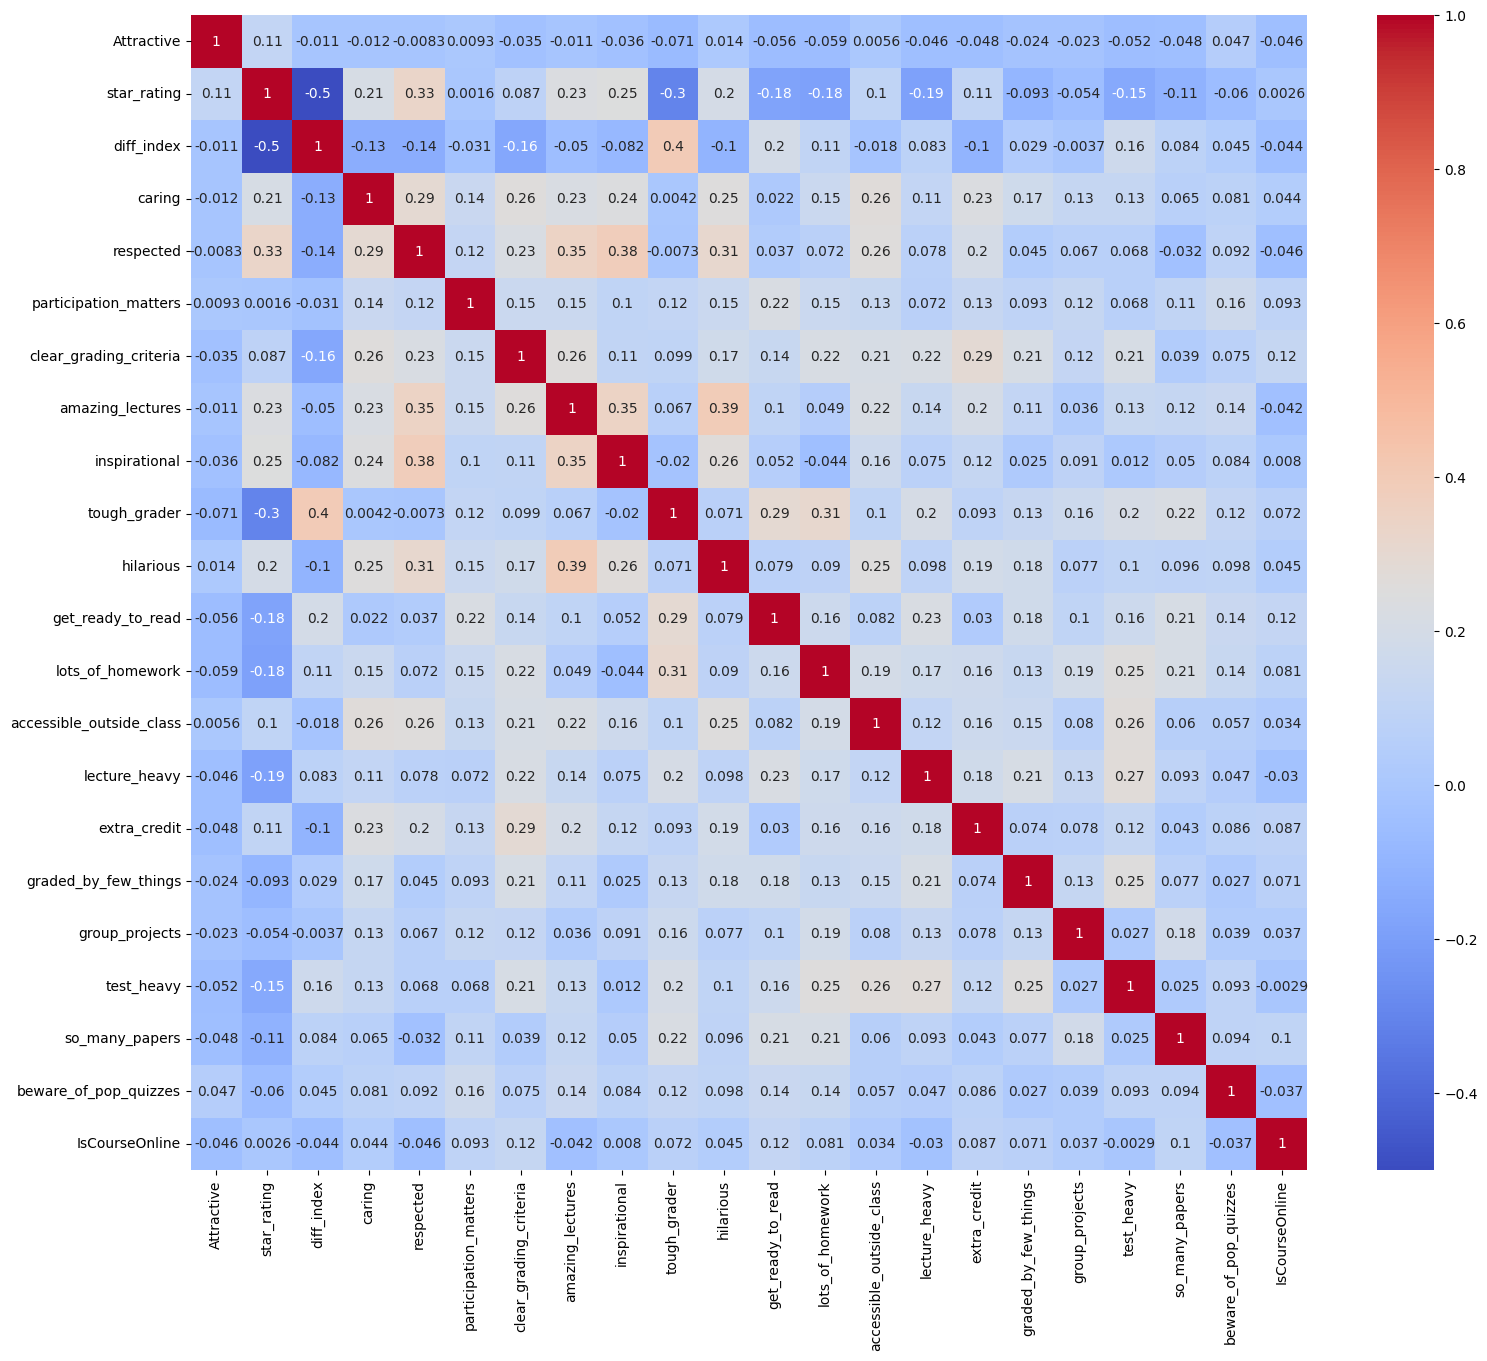

In [86]:
data = pd.read_csv('rmp2.csv') #loading in data
re_pattern = "cute|attractive| hot|handsome|good-looking|gorgeous|adorable|stunning|sexy|eye-candy|beautiful" #ChatGPT probably contributed to this list
data['Attractive'] = 0 #initializing Attractive to zero all around
data.head()


## Uses regex to find the words in the comments column and then adds a 1 to the Attractive column if the word is found
for index, row in data.iterrows():
    reg = re.findall(re_pattern, str(row['comments']).lower())
    if len(reg) >= 1:
        #new_list.append(row['comments'])
        data.at[index, 'Attractive'] = 1
"""Dropping most of the columns that we don't need"""
data_less = data[['professor_name', 'Attractive', 'star_rating', 'diff_index', 'student_star', 'tag_professor', 'gives_good_feedback', 'caring', 'respected', 'participation_matters', 'clear_grading_criteria', 'skip_class', 'amazing_lectures', 'inspirational', 'tough_grader', 'hilarious', 'get_ready_to_read', 'lots_of_homework', 'accessible_outside_class', 'lecture_heavy', 'extra_credit', 'graded_by_few_things', 'group_projects', 'test_heavy', 'so_many_papers', 'beware_of_pop_quizzes', 'IsCourseOnline']]

data_less_with_things_2 = data_less[(data_less['tag_professor'].notna()) & (data_less['tag_professor'] != '')] #keeps only the rows that have a tag_professor | ChatGPT contributed the .notna() part

# counts the number of total reviews for each professor, adds that to a new column
data_less_with_things_2['total_reviews'] = data_less_with_things_2.groupby('professor_name')['professor_name'].transform('count')
# Makes the attraciveness column for every review the average attraciveness for that professor
data_less_with_things_2['Attractive'] = data_less_with_things_2.groupby('professor_name')['Attractive'].transform('mean')
professor_data = data_less_with_things_2.drop_duplicates(subset=['professor_name'], keep='first') #drops all reviews for each professor except for the first. Nothing important is lost as everything left is the same for each review of a professor
tags_list = ['gives_good_feedback', 'caring', 'respected', 'participation_matters', 'clear_grading_criteria', 'skip_class', 'amazing_lectures', 'inspirational', 'tough_grader', 'hilarious', 'get_ready_to_read', 'lots_of_homework', 'accessible_outside_class', 'lecture_heavy', 'extra_credit', 'graded_by_few_things', 'group_projects', 'test_heavy', 'so_many_papers', 'beware_of_pop_quizzes', 'IsCourseOnline']


professor_data.to_csv('professor_data.csv')

plt.figure(figsize=(18, 15))
sns.heatmap(professor_data.drop(['professor_name', 'tag_professor', 'student_star', 'skip_class', 'gives_good_feedback', 'total_reviews'], axis=1).corr(), annot=True, cmap='coolwarm')
# ChatGPT made this graph's index a little nicer

## Chi Square Tests
- Each dependent pair of features is printed, along with its p-value and grid

In [265]:
# chi square tests comparing attractive to all the other features
from scipy.stats import chi2_contingency
tester = np.array([[0, 0], [0, 0]])
x = ['caring', 'respected', 'participation_matters', 'clear_grading_criteria', 'skip_class', 'amazing_lectures', 'inspirational', 'tough_grader', 'hilarious', 'get_ready_to_read', 'lots_of_homework', 'accessible_outside_class', 'lecture_heavy', 'extra_credit', 'graded_by_few_things', 'group_projects', 'test_heavy', 'so_many_papers', 'beware_of_pop_quizzes', 'IsCourseOnline']
counter_dict = {}
myset = set()
for j in x: ## I'm sorry about the O(N^2 * M) complexity
    for i in x:
        if i != j:
            tester = np.array([[0, 0], [0, 0]])
            for index, row in professor_data.iterrows():
                if row[j] > 0 and row[i] == 1:
                    tester[0][0] += 1
                elif row[j] > 0 and row[i] == 0:
                    tester[0][1] += 1
                elif row[j] == 0 and row[i] == 1:
                    tester[1][0] += 1
                elif row[j] == 0 and row[i] == 0:
                    tester[1][1] += 1
            _, p, _, _ = chi2_contingency(tester)
            if p < 0.05 and j + ' and ' + i not in myset and i + ' and ' + j not in myset:
                print(j + ' and ' + i + ' | p-value: ' + str(p))
                myset.add(j + ' and ' + i)
                print(tester)
                print("\n")
                if j in counter_dict:
                    counter_dict[j] += 1
                if i in counter_dict:
                    counter_dict[i] += 1
                if j not in counter_dict:
                    counter_dict[j] = 1
                if i not in counter_dict:
                    counter_dict[i] = 1
for i in counter_dict:
    print(i + ' | ' + str(counter_dict[i]))

caring and respected | p-value: 3.730849110588085e-13
[[189 102]
 [119 216]]


caring and participation_matters | p-value: 0.0005468174698148895
[[145 146]
 [120 215]]


caring and clear_grading_criteria | p-value: 2.429070132714339e-10
[[148 143]
 [ 87 248]]


caring and skip_class | p-value: 5.265034951086794e-06
[[166 125]
 [129 206]]


caring and amazing_lectures | p-value: 2.4319385242123334e-08
[[134 157]
 [ 82 253]]


caring and inspirational | p-value: 1.9989267571514376e-09
[[138 153]
 [ 81 254]]


caring and hilarious | p-value: 3.792135599478641e-10
[[134 157]
 [ 74 261]]


caring and lots_of_homework | p-value: 0.000388953288732961
[[120 171]
 [ 92 243]]


caring and accessible_outside_class | p-value: 6.4365800170211e-11
[[ 99 192]
 [ 40 295]]


caring and lecture_heavy | p-value: 0.005724894314348595
[[125 166]
 [107 228]]


caring and extra_credit | p-value: 9.845801883765693e-09
[[ 85 206]
 [ 36 299]]


caring and graded_by_few_things | p-value: 2.782736105512288e-05
[[

## Visualizations for EDA
- Seaborn histogram
- Seaborn violin plot

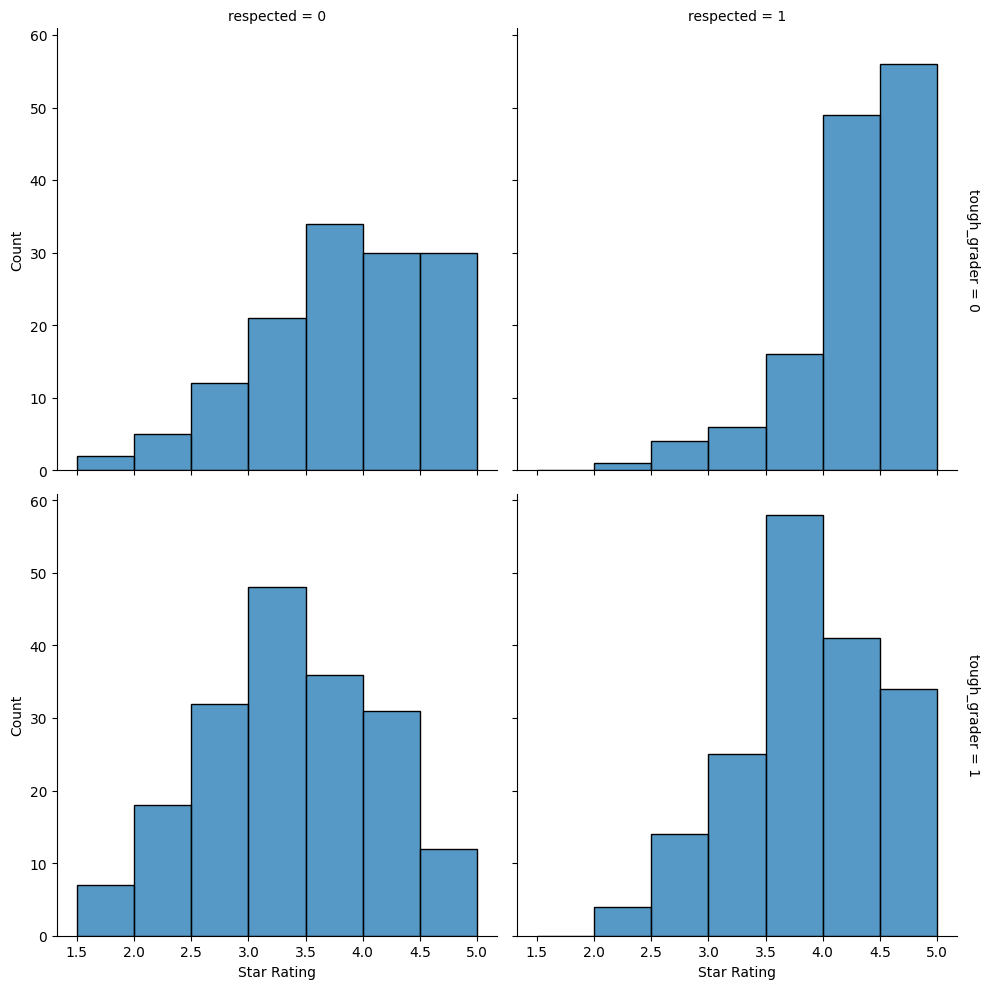

In [39]:
hist = sns.displot(
    professor_data, x="star_rating", col="respected", row="tough_grader",
    binwidth=0.5, height=5, facet_kws=dict(margin_titles=True),
)
hist.set_axis_labels("Star Rating", "Count")
hist

Text(0.5, 1.0, 'Star Rating vs. Lots of Homework and Inspirational')

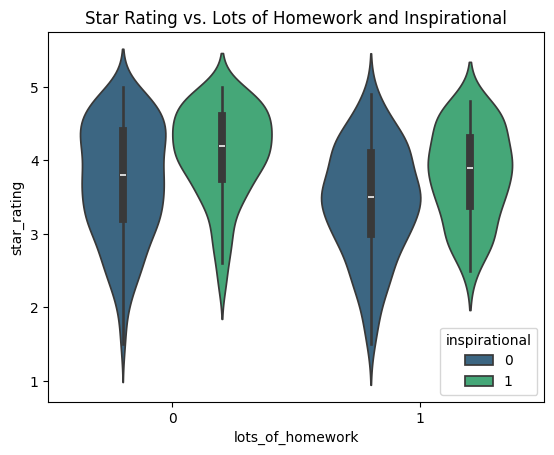

In [84]:
violin = sns.violinplot(data=professor_data, y="star_rating", x="lots_of_homework", hue="inspirational", palette='viridis')
# add a title
plt.title("Star Rating vs. Lots of Homework and Inspirational")

## Data Manipulation to ready for Machine Learning

In [100]:
import re


def get_tags(text):
    """Uses a regex expression to parse the complicated tag_professor column and turn this into a dictionary which we can use to create more informative tag columns"""
    result_dict = {}
    matches = re.findall(r'(.+?)\s*\((\d+)\)', text) ## CHatGPT's biggest source of help. This is a regex that finds all the tags and their values
    for key, value in matches:
        result_dict[key.strip()] = int(value)
    return result_dict

# Tags are listed slightly differently in the tag_professor column, so we need to convert them to the same format as our dataframe has for its column names
convert_to_standard = {"LECTURE HEAVY": "lecture_heavy", "Gives good feedback": "gives_good_feecback", "Caring": "caring", "Respected": "respected", "Participation matters": "participation_matters", "Clear grading criteria": "clear_grading_criteria", "Skip class? You won't pass.": "skip_class", "Amazing lectures": "amazing_lectures", "Inspirational": "inspirational", "Tough Grader": "tough_grader", "Hilarious": "hilarious", "Get ready to read": "get_ready_to_read",
"LOTS OF HOMEWORK": "lots_of_homework", "ACCESSIBLE OUTSIDE CLASS": "accessible_outside_class", "EXTRA CREDIT": "extra_credit", "GRADED BY FEW THINGS": "graded_by_few_things", "GROUP PROJECTS": "group_projects", "TEST HEAVY": "test_heavy", "SO MANY PAPERS": "so_many_papers", "BEWARE OF POP QUIZZES": "beware_of_pop_quizzes", "IS COURSE ONLINE?": "IsCourseOnline"}

professor_data['Attractive'] = professor_data['Attractive']*4 #multiplies attractiveness by 4

for index, row in professor_data.iterrows(): # Updates the dataframe with the new columns, and scales the values based on the number of total reviews that professor has
    tags = get_tags(row['tag_professor'])
    for key in tags.keys():
        if key in convert_to_standard:
            newkey = convert_to_standard[key]
        professor_data.at[index, newkey] = min(1, float(tags[key])/float(row['total_reviews']))


## Attractiveness metric testing
- Iterates through every line (20,000) and grades comments on attractivness on either regex or NLP
- This was used heavily early in the project as we attempted to find a combination of embeddings and regex that would accurately identify comments about the professor being attractive
- In this case, the code prints out comments and cosine values for reviews with a cosine value higher than 0.5 (compared to one of our many tested model sentences)

In [268]:
maxx = 0
yes_count = 0
no_count = 0
re_pattern = "cute|attractive| hot|handsome|good-looking|gorgeous|adorable|stunning|sexy|eye-candy|beautiful"
sentence = "sexy cute hot handsome attractive"
sentence2 = "An awesome teacher, being cute, attractive, hot, handsome, good-looking, gorgeous, adorable, stunning, sexy, eye-candy, beautiful, and pretty."
sentence3 = "super nice, easy, and helful, and an awesome teacher, or very boring, unhelpful, and bad"
sentence4 = "His wife is a lucky woman"
sentence5 = "He is a great professor"
new_list = []
attractiveness_x = []
reg_y = []

for index, row in data.iterrows():
    comment = str(row['comments']).lower()
    comment = ' '.join(get_adjectives(comment))
    comment_cos = find_cosine(find_avg_vector(comment, wv), find_avg_vector(sentence,wv))
    attractiveness_x.append(comment_cos)
    if comment_cos > 0.5:
        print(comment_cos)
        print(row['comments'])
        print(row['professor_name'])
        print("")
    reg = re.findall(re_pattern, str(row['comments']).lower())
    reg_y.append(len(reg))



0.5193045
This class is hard, but its a two-in-one gen-ed knockout, and the content is very stimulating. Unlike most classes, you have to actually participate to pass. Sections are easy and offer extra credit every week. Very funny dude. Not much more I can say.
Leslie  Looney

0.523931
"Sexy Boy". Killer Skies was one of the best classes I\'ve taken. Looney kept me excited for class and did presentations effectively and with great humor. Highly recommend him in general. Online quizzes were tough but given multiple chances. Exams are somewhat hard so study. Never a dry moment, great guy, great topics. You\'re gonna have fun. Ciao
Leslie  Looney

0.52255636
Excellent professor. Hilarious, fun, and good.
Leslie  Looney

0.49007663
A kind, knowledgeable, phenomenal teacher. I would recommend any of his classes. He is hilarious, engaging, and intelligent. This class was so far from my major, and yet I enjoyed class everyday. Study, its astronomy. But Looney is fantastic.
Leslie  Looney

0.

## Comparison of NLP and regex results for the data

In [ ]:
plt.plot(attractiveness_x, reg_y ,'o')
plt.xlabel('NLP: cosine similarity')
plt.ylabel('Regex: Number of attractiveness words')

## Random Forest Classification (and framework for others)

In [98]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV as RSCV


# This gets rid of all rows where the user did not enter a single 1 in the boolean tags
data_less_with_things_2 = data_less[(data_less['Attractive'] == 1) | (data_less['caring'] == 1) | (data_less['gives_good_feedback'] == 1) | (data_less['respected'] == 1) | (data_less['participation_matters'] == 1) | (data_less['clear_grading_criteria'] == 1) | (data_less['skip_class'] == 1) | (data_less['amazing_lectures'] == 1) | (data_less['inspirational'] == 1) | (data_less['tough_grader'] == 1) | (data_less['hilarious'] == 1) | (data_less['get_ready_to_read'] == 1) | (data_less['lots_of_homework'] == 1) | (data_less['accessible_outside_class'] == 1) | (data_less['lecture_heavy'] == 1) | (data_less['extra_credit'] == 1) | (data_less['graded_by_few_things'] == 1) | (data_less['group_projects'] == 1) | (data_less['test_heavy'] == 1) | (data_less['so_many_papers'] == 1) | (data_less['beware_of_pop_quizzes'] == 1) | (data_less['IsCourseOnline'] == 1)] #ChatGPT fixed my syntax
y_wit_things = professor_data['star_rating']
x_wit_things = professor_data[['Attractive', 'caring', 'gives_good_feedback', 'respected', 'participation_matters', 'clear_grading_criteria', 'skip_class', 'amazing_lectures', 'inspirational', 'tough_grader', 'hilarious', 'get_ready_to_read', 'lots_of_homework', 'accessible_outside_class', 'lecture_heavy', 'extra_credit', 'graded_by_few_things', 'group_projects', 'test_heavy', 'so_many_papers', 'beware_of_pop_quizzes', 'IsCourseOnline']]
x_wit_less_things = x_wit_things[['Attractive','respected', 'inspirational', 'tough_grader']] #Experiments with less features did not improve the model 
y_classifications = y_wit_things.apply(lambda x: 1 if x >= 3.7 else 0) #lambda was an easy way to turn the star ratings from continuous (for the regression) to discrete (for the classification)



x_train, x_test, y_train, y_test = \
    train_test_split(x_wit_things, y_classifications, test_size=0.15, random_state=110)

param_grid = {'n_estimators':np.arange(50,200,15),
              'max_features':np.arange(0.1, 1, 0.1),
              'max_depth': [3,5,7],
              'max_samples': [0.3, 0.5, 0.8]}

model = RSCV(RandomForestClassifier(), param_grid, n_iter = 15).fit(x_train, y_train)
model = model.best_estimator_
params = model.get_params()
print(params)
print(cross_val_score(model, x_train, y_train))
print(model.score(x_test, y_test))
print(model.feature_importances_)



{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 0.6, 'max_leaf_nodes': None, 'max_samples': 0.5, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 110, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
[0.76635514 0.68224299 0.68867925 0.66981132 0.69811321]
0.648936170212766
[0.02052512 0.09703915 0.01585797 0.21084533 0.01814732 0.01803269
 0.00382097 0.07280719 0.0655476  0.16543833 0.03300888 0.0618525
 0.0412219  0.01493831 0.05852524 0.0108421  0.00504325 0.013378
 0.04626042 0.01454556 0.00896774 0.00335444]


## Feature importances of the regression

C:\Users\cowan\AppData\Local\Temp\ipykernel_74856\1976466506.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_wit_things.columns, y=model.feature_importances_, palette=['blue', 'orange', 'blue', 'orange', 'blue', 'blue', 'blue', 'orange', 'blue', 'orange', 'blue', 'orange', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue'])


Text(0, 0.5, 'Feature Importance')

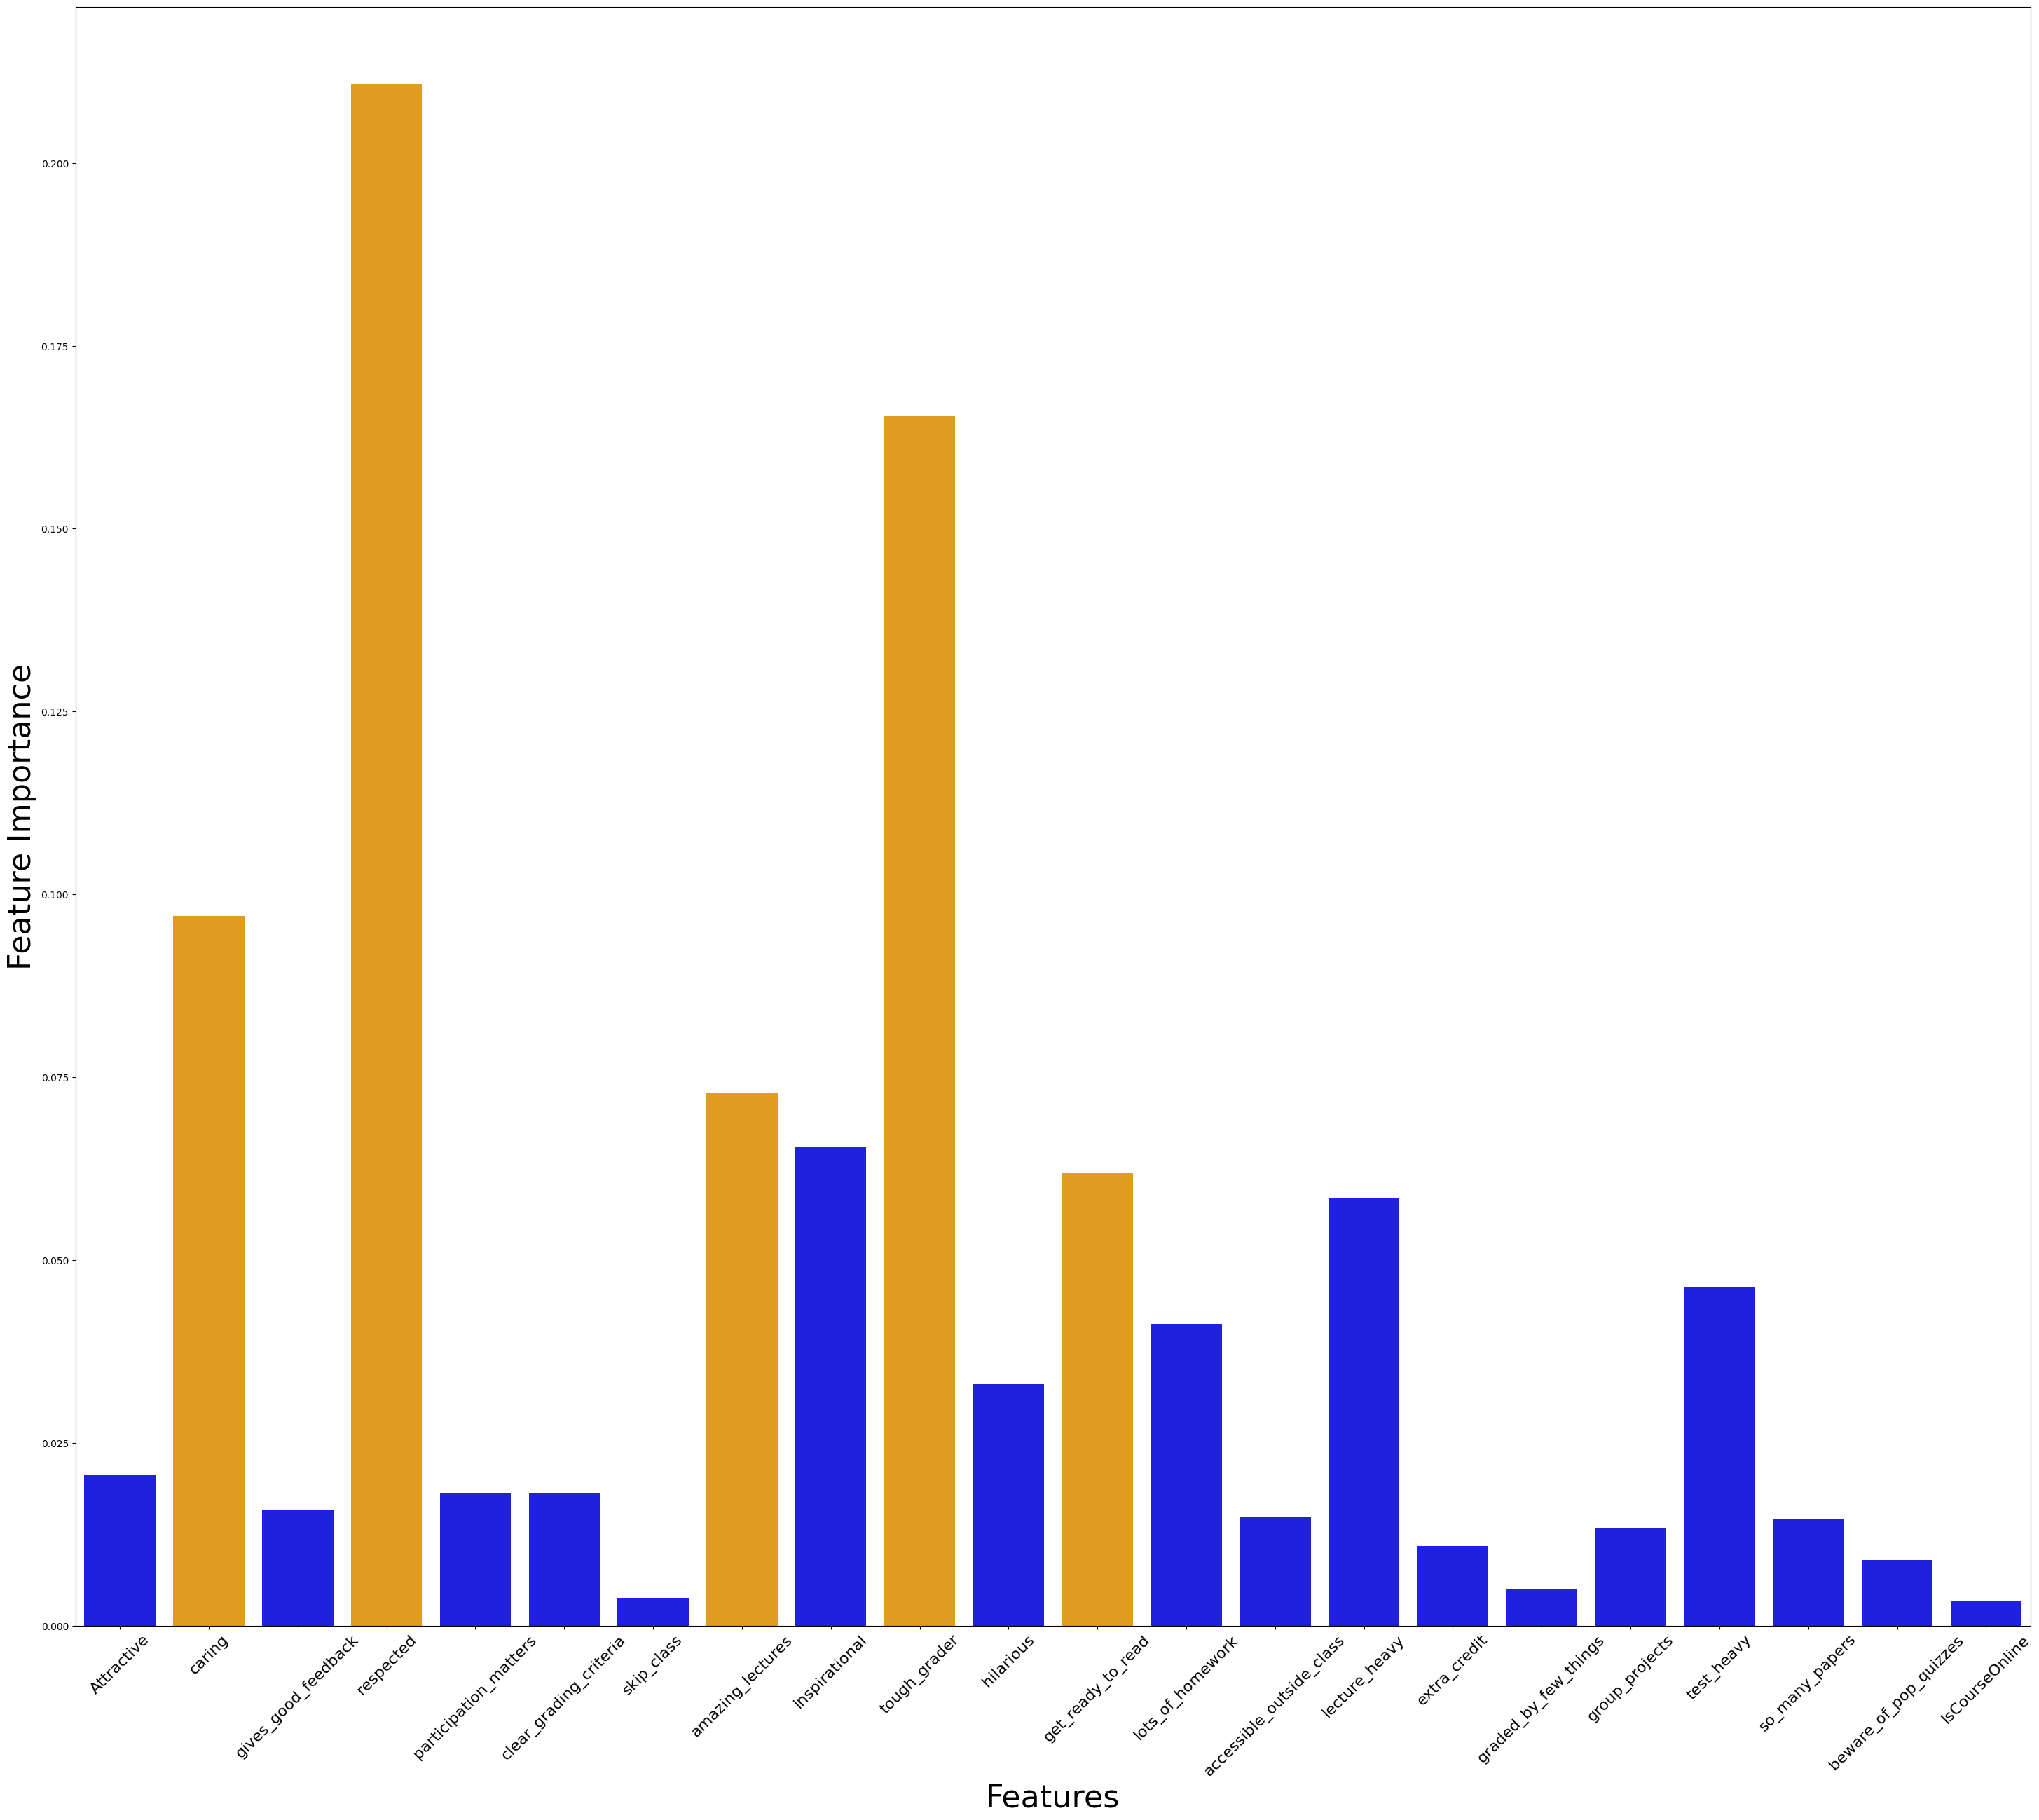

In [99]:
plt.figure(figsize=(36, 30))
sns.barplot(x=x_wit_things.columns, y=model.feature_importances_, palette=['blue', 'orange', 'blue', 'orange', 'blue', 'blue', 'blue', 'orange', 'blue', 'orange', 'blue', 'orange', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue'])
plt.xticks(fontsize=16, rotation=45)
plt.xlabel('Features', fontsize=32)
plt.ylabel('Feature Importance', fontsize=32)

## ElasticNet Regression
- Our failed ElasticNet regression model. R^2 of validation data did not pass ~0.26, and generally averaged ~0.2

{'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.36363636363636365, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
[ 0.47716485  0.80174561  1.02712395  0.3360523   0.22403554  0.39142494
  0.66682038 -1.00475921  0.62927477 -0.37356985 -0.83925509 -0.
 -0.77889171  0.075631    0.         -0.46879813 -0.         -0.
  0.23924172  0.09855267]
3.7142770585874083
[0.24291853 0.13690946 0.21776595 0.26773796 0.15562873]


Text(0, 0.5, 'Actual Rating')

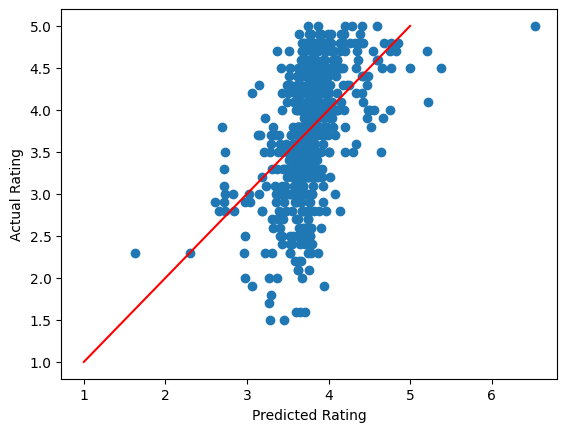

In [102]:
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

x = professor_data[['Attractive', 'caring', 'respected', 'participation_matters', 'clear_grading_criteria', 'amazing_lectures', 'inspirational', 'tough_grader', 'hilarious', 'get_ready_to_read', 'lots_of_homework', 'accessible_outside_class', 'lecture_heavy', 'extra_credit', 'graded_by_few_things', 'group_projects', 'test_heavy', 'so_many_papers', 'beware_of_pop_quizzes', 'IsCourseOnline']]
y = professor_data['star_rating']


x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.15)
#model = LinearRegression()


regr = ElasticNet(random_state=0)
regr.fit(x_train, y_train)

# Create a hyperparameter grid
param_grid = { ## ChatGPT helped with this
    'alpha': np.logspace(-4, 4, 9),  # alpha values from 0.0001 to 10000
    'l1_ratio': np.linspace(0, 1, 100)  # l1_ratio values from 0 to 1S
}
model = RSCV(ElasticNet(), param_grid, n_iter = 15).fit(x_train, y_train)
model = model.best_estimator_
#model = LinearRegression()
#model.fit(x_train, y_train)
params = model.get_params()
print(params)
print(model.coef_)
print(model.intercept_)
# cross val score
print(cross_val_score(model, x_train, y_train))
yhat = model.predict(x)
plt.scatter(yhat, y)
plt.plot([1,5], [1,5], 'r')
plt.xlabel('Predicted Rating')
plt.ylabel('Actual Rating')
#print(y_test[0])
# for i in range(len(x_test)):
#     print(i)
#     print(x_test.iloc[i])
#     #print(y_test[:10])
#     #print(model.predict(x_test[i]))


## Scipy T-tests

Attractive
4.012048192771085
83
0.0006054397489588208

Not Attractive
3.7068139963167566
543
0.0006054397489588208

caring
3.9063973063973036
297
4.768920664623947e-07

Not caring
3.6036474164133727
329
4.768920664623947e-07

respected
4.000324675324673
308
2.987283476756711e-17

Not respected
3.5022012578616346
318
2.987283476756711e-17

participation_matters
3.745724907063195
269
0.9643998123910218

Not participation_matters
3.748459383753497
357
0.9643998123910218

clear_grading_criteria
3.8326271186440652
236
0.028294683579308356

Not clear_grading_criteria
3.6956410256410197
390
0.028294683579308356

skip_class
3.6484745762711848
295
0.0020187735053216935

Not skip_class
3.835347432024167
331
0.0020187735053216935

amazing_lectures
3.985844748858445
219
4.937819689192559e-09

Not amazing_lectures
3.618918918918915
407
4.937819689192559e-09

inspirational
3.996380090497737
221
7.291197738697292e-10

Not inspirational
3.611358024691355
405
7.291197738697292e-10

tough_grader
3.55166

C:\Users\cowan\AppData\Local\Temp\ipykernel_48824\760144288.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[feature, 'Not ' + feature], y=[p_val_dict[feature][1], p_val_dict['Not ' + feature][1]], palette='Blues_d')


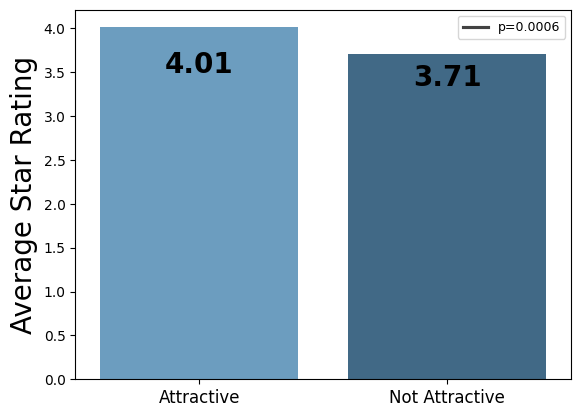

C:\Users\cowan\AppData\Local\Temp\ipykernel_48824\760144288.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[feature, 'Not ' + feature], y=[p_val_dict[feature][1], p_val_dict['Not ' + feature][1]], palette='Blues_d')


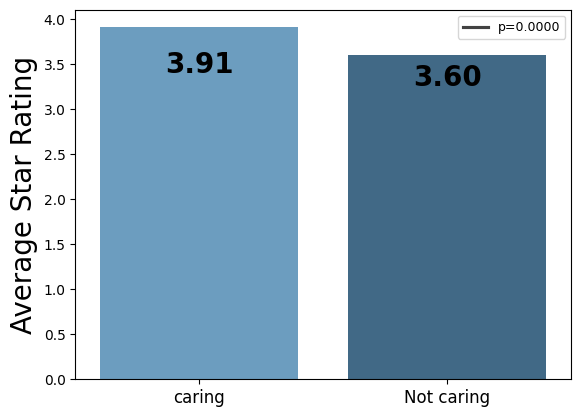

C:\Users\cowan\AppData\Local\Temp\ipykernel_48824\760144288.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[feature, 'Not ' + feature], y=[p_val_dict[feature][1], p_val_dict['Not ' + feature][1]], palette='Blues_d')


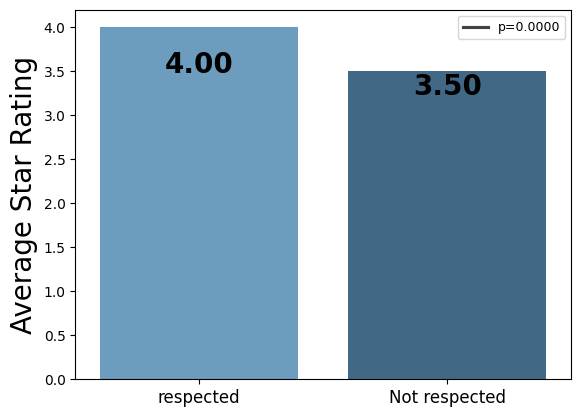

C:\Users\cowan\AppData\Local\Temp\ipykernel_48824\760144288.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[feature, 'Not ' + feature], y=[p_val_dict[feature][1], p_val_dict['Not ' + feature][1]], palette='Blues_d')


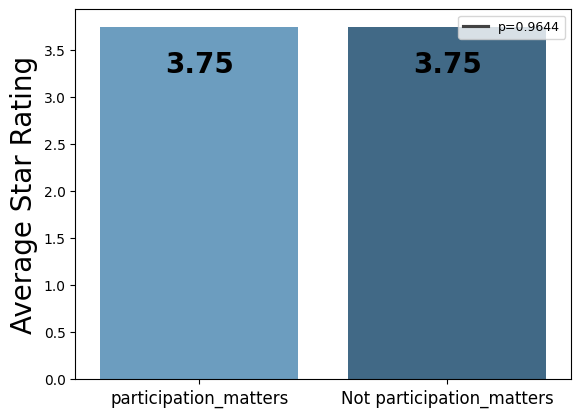

C:\Users\cowan\AppData\Local\Temp\ipykernel_48824\760144288.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[feature, 'Not ' + feature], y=[p_val_dict[feature][1], p_val_dict['Not ' + feature][1]], palette='Blues_d')


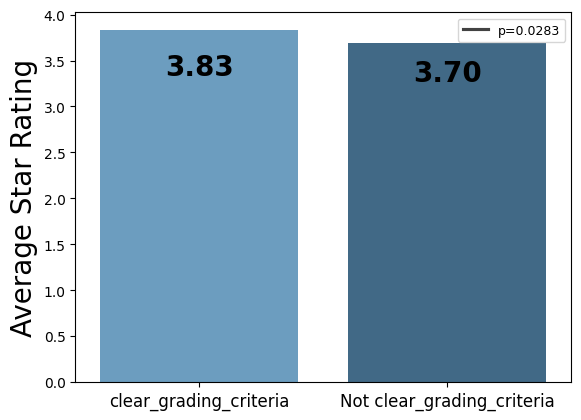

C:\Users\cowan\AppData\Local\Temp\ipykernel_48824\760144288.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[feature, 'Not ' + feature], y=[p_val_dict[feature][1], p_val_dict['Not ' + feature][1]], palette='Blues_d')


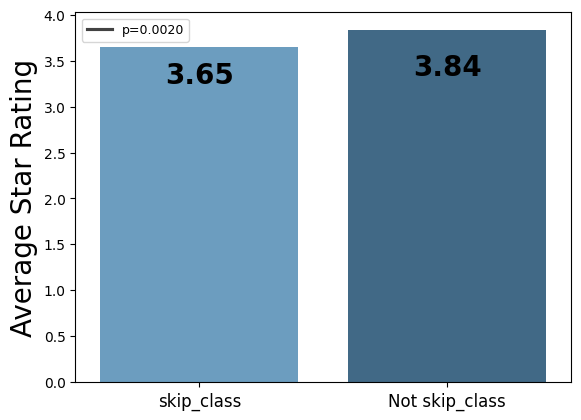

C:\Users\cowan\AppData\Local\Temp\ipykernel_48824\760144288.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[feature, 'Not ' + feature], y=[p_val_dict[feature][1], p_val_dict['Not ' + feature][1]], palette='Blues_d')


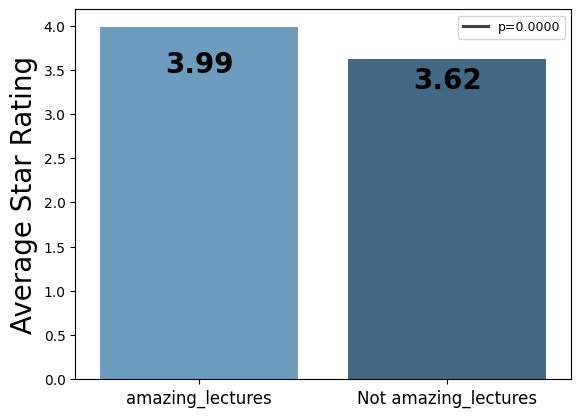

C:\Users\cowan\AppData\Local\Temp\ipykernel_48824\760144288.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[feature, 'Not ' + feature], y=[p_val_dict[feature][1], p_val_dict['Not ' + feature][1]], palette='Blues_d')


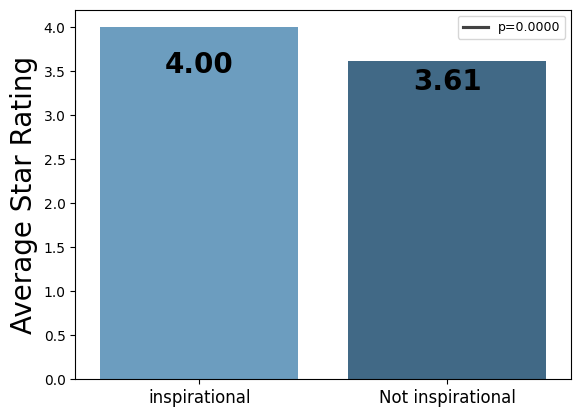

C:\Users\cowan\AppData\Local\Temp\ipykernel_48824\760144288.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[feature, 'Not ' + feature], y=[p_val_dict[feature][1], p_val_dict['Not ' + feature][1]], palette='Blues_d')


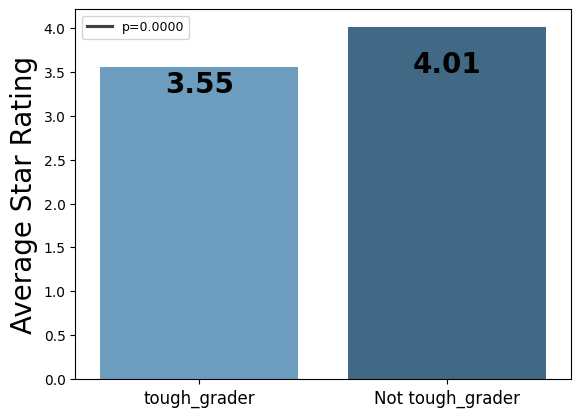

C:\Users\cowan\AppData\Local\Temp\ipykernel_48824\760144288.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[feature, 'Not ' + feature], y=[p_val_dict[feature][1], p_val_dict['Not ' + feature][1]], palette='Blues_d')


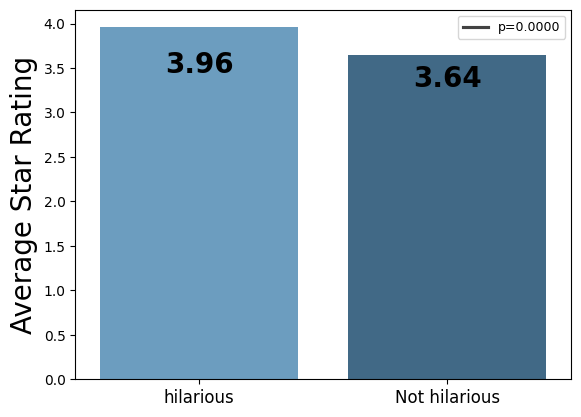

C:\Users\cowan\AppData\Local\Temp\ipykernel_48824\760144288.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[feature, 'Not ' + feature], y=[p_val_dict[feature][1], p_val_dict['Not ' + feature][1]], palette='Blues_d')


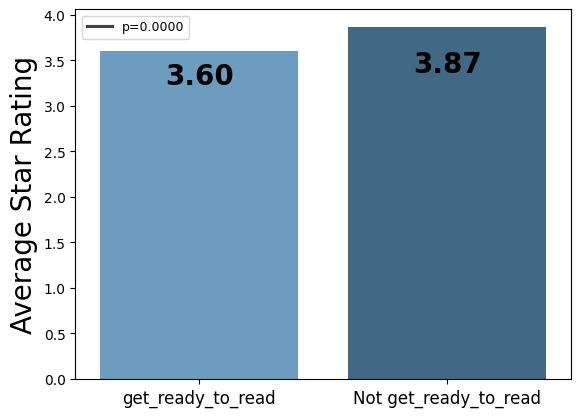

C:\Users\cowan\AppData\Local\Temp\ipykernel_48824\760144288.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[feature, 'Not ' + feature], y=[p_val_dict[feature][1], p_val_dict['Not ' + feature][1]], palette='Blues_d')


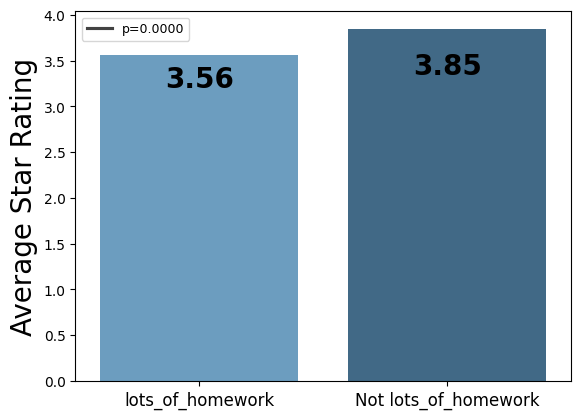

C:\Users\cowan\AppData\Local\Temp\ipykernel_48824\760144288.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[feature, 'Not ' + feature], y=[p_val_dict[feature][1], p_val_dict['Not ' + feature][1]], palette='Blues_d')


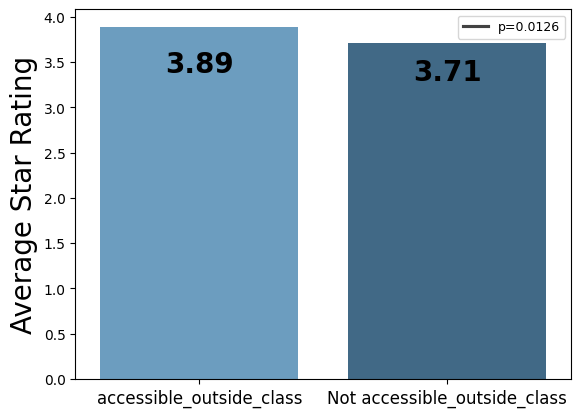

C:\Users\cowan\AppData\Local\Temp\ipykernel_48824\760144288.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[feature, 'Not ' + feature], y=[p_val_dict[feature][1], p_val_dict['Not ' + feature][1]], palette='Blues_d')


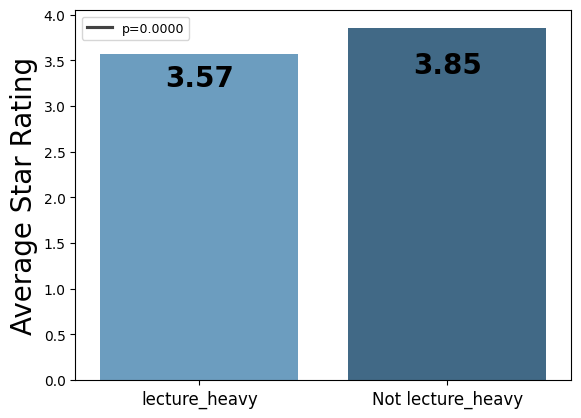

C:\Users\cowan\AppData\Local\Temp\ipykernel_48824\760144288.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[feature, 'Not ' + feature], y=[p_val_dict[feature][1], p_val_dict['Not ' + feature][1]], palette='Blues_d')


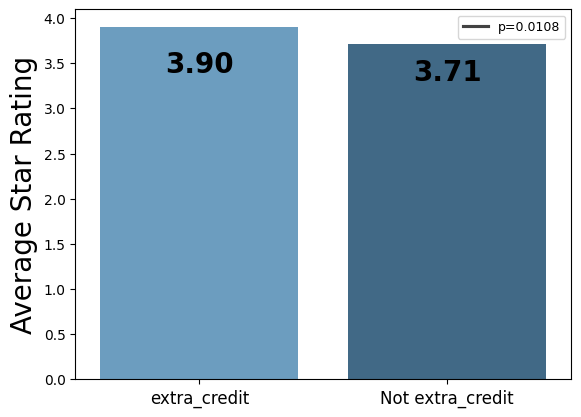

C:\Users\cowan\AppData\Local\Temp\ipykernel_48824\760144288.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[feature, 'Not ' + feature], y=[p_val_dict[feature][1], p_val_dict['Not ' + feature][1]], palette='Blues_d')


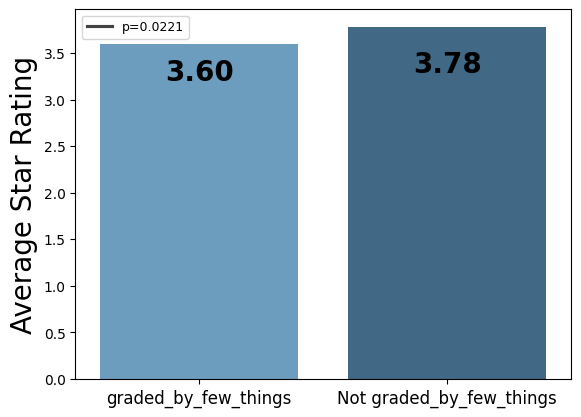

C:\Users\cowan\AppData\Local\Temp\ipykernel_48824\760144288.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[feature, 'Not ' + feature], y=[p_val_dict[feature][1], p_val_dict['Not ' + feature][1]], palette='Blues_d')


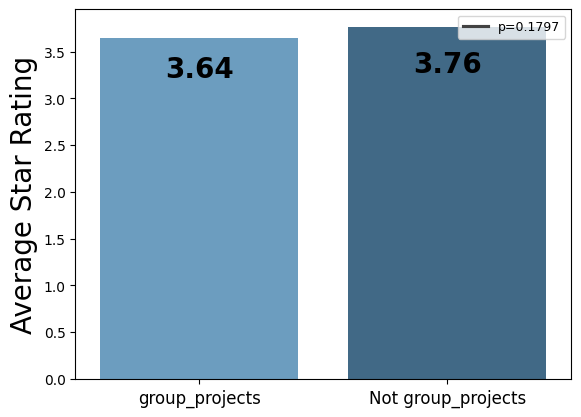

C:\Users\cowan\AppData\Local\Temp\ipykernel_48824\760144288.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[feature, 'Not ' + feature], y=[p_val_dict[feature][1], p_val_dict['Not ' + feature][1]], palette='Blues_d')


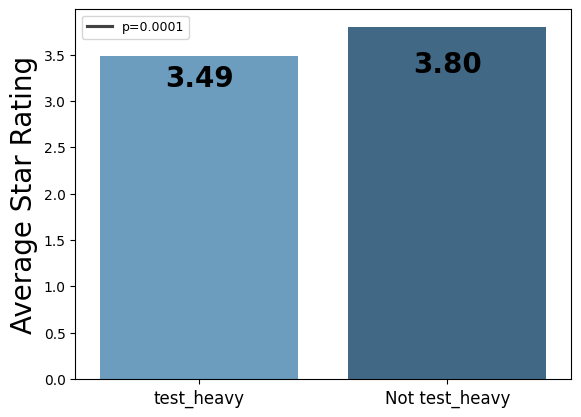

C:\Users\cowan\AppData\Local\Temp\ipykernel_48824\760144288.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[feature, 'Not ' + feature], y=[p_val_dict[feature][1], p_val_dict['Not ' + feature][1]], palette='Blues_d')


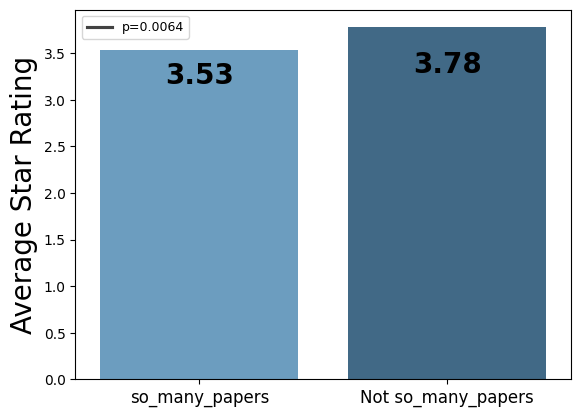

C:\Users\cowan\AppData\Local\Temp\ipykernel_48824\760144288.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[feature, 'Not ' + feature], y=[p_val_dict[feature][1], p_val_dict['Not ' + feature][1]], palette='Blues_d')


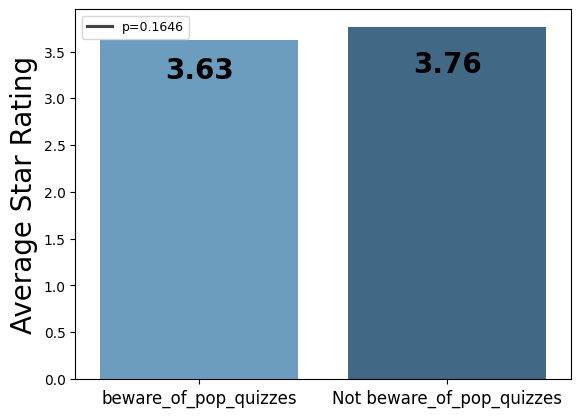

C:\Users\cowan\AppData\Local\Temp\ipykernel_48824\760144288.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[feature, 'Not ' + feature], y=[p_val_dict[feature][1], p_val_dict['Not ' + feature][1]], palette='Blues_d')


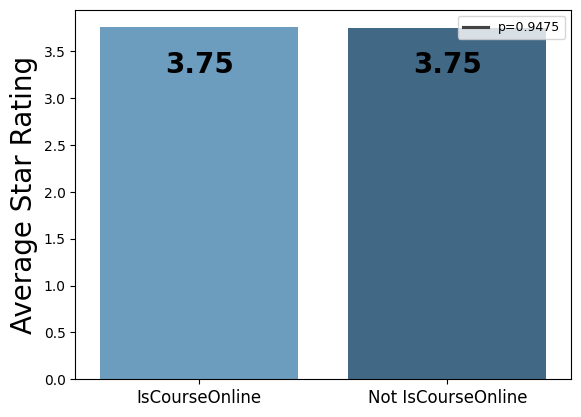

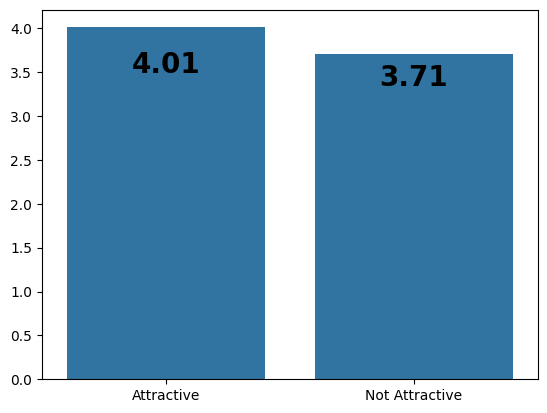

In [274]:
import scipy
# create an array with star_rating of people rated as attracive

x = ['Attractive', 'caring', 'respected', 'participation_matters', 'clear_grading_criteria', 'skip_class', 'amazing_lectures', 'inspirational', 'tough_grader', 'hilarious', 'get_ready_to_read', 'lots_of_homework', 'accessible_outside_class', 'lecture_heavy', 'extra_credit', 'graded_by_few_things', 'group_projects', 'test_heavy', 'so_many_papers', 'beware_of_pop_quizzes', 'IsCourseOnline']
features_dict = {}
p_val_dict = {}
for i in x:
    #print(features_dict)
    features_dict[i] = []
    features_dict['Not ' + i] = []
    for index, row in professor_data.iterrows():
        if row[i] > 0:
            features_dict[i].append(row['star_rating'])
        else:
            features_dict['Not ' + i].append(row['star_rating'])

for i in features_dict.keys():
    print(i)
    if len(features_dict[i]) == 0:
        print("\n")
        continue
    print(sum(features_dict[i])/len(features_dict[i]))
    print(len(features_dict[i]))
    if i[:3] == 'Not':
        pass
    else:
        _, p = scipy.stats.ttest_ind(features_dict['Not ' + i], features_dict[i])
    print(f'{p}\n')
    p_val_dict[i] = []
    p_val_dict[i].append(p)
    p_val_dict[i].append(sum(features_dict[i])/len(features_dict[i]))

attractive = []
not_attractive = []


def create_barplot(feature):
    """ChatGPT wrote most of the annotation part although I messed with it to get exactly what I wanted"""
    ax = sns.barplot(x=[feature, 'Not ' + feature], y=[p_val_dict[feature][1], p_val_dict['Not ' + feature][1]], palette='Blues_d')
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()/2),
                    ha='center', va='center', xytext=(0, 100), textcoords='offset points',
                    weight='bold', color='black', fontsize=20, 
                    #axis titles for average star rating on y and feature on x           
        )
    plt.ylabel('Average Star Rating', fontsize=20)
    #plt.xlabel('Feature', fontsize=20)
    plt.legend([f'p={p_val_dict[feature][0]:.4f}'], fontsize=9)
    plt.xticks(fontsize=12)
    # Show the plot
    plt.show()



for i in features_dict:
    if i[:3] == 'Not':
        pass
    else:
        create_barplot(i)


ax = sns.barplot(x=['Attractive', 'Not Attractive'], y=[p_val_dict['Attractive'][1], p_val_dict['Not Attractive'][1]])
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()/2),
                ha='center', va='center', xytext=(0, 100), textcoords='offset points',
                weight='bold', color='black', fontsize=20,
                #axis titles for average star rating on y and feature on x
                
    )
# plt.ylabel('Average Star Rating', fontsize=20)
# plt.xlabel('Feature', fontsize=20)
# # Show the plot
plt.show()
#ax
# for index, row in data2.iterrows():
#     if row['Attractive'] > 0:
#         attractive.append(row['star_rating'])
#     else:
#         not_attractive.append(row['star_rating'])
# print(len(attractive))
# print(len(not_attractive[:len(attractive)]))
# print(sum(attractive)/len(attractive))
# print(sum(not_attractive)/len(not_attractive))
# _, p = scipy.stats.ttest_ind(attractive[:len(attractive)], not_attractive)
# p

In [275]:
## ChatGPT wrote this code

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
print(data2)
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def get_adjectives(sentence):
    # Tokenize the sentence into words
    words = word_tokenize(sentence)

    # Perform part-of-speech tagging
    tagged_words = pos_tag(words)

    # Filter words based on their part-of-speech tags (adjectives)
    adjectives = [word for word, tag in tagged_words if tag.startswith('JJ')]

    return adjectives


                    Attractive  star_rating  diff_index  student_star  \
professor_name                                                          
Aaron  Fogel                 0         80.0        60.0          73.0   
Aaron  Kozbelt               0         94.0        64.0          93.0   
Aimee  Miller                0         72.0        64.0          67.5   
Alan  Cavaiola               0         86.0        56.0          85.5   
Alan  Kaminsky               0         58.0        78.0          50.0   
...                        ...          ...         ...           ...   
Y. Peter  Chung              0         64.0        74.0          66.0   
Yasmin  Villvendas           1         90.0        38.0          93.0   
Ying  Wang                   1         98.0        50.0          97.5   
Younghe  Kim Park            0         80.0        56.0          69.0   
Zeynep  Tenger               0         56.0        43.2          57.0   

                                                  

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cowan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\cowan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Seaborn Joint Plot comparing amazing lecturers with professors who assign a lot of reading

C:\Users\cowan\AppData\Local\Temp\ipykernel_74856\657632862.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  professor_data["amazing_lectures"] = professor_data["amazing_lectures"].apply(lambda x: 1 if x > 0 else 0)


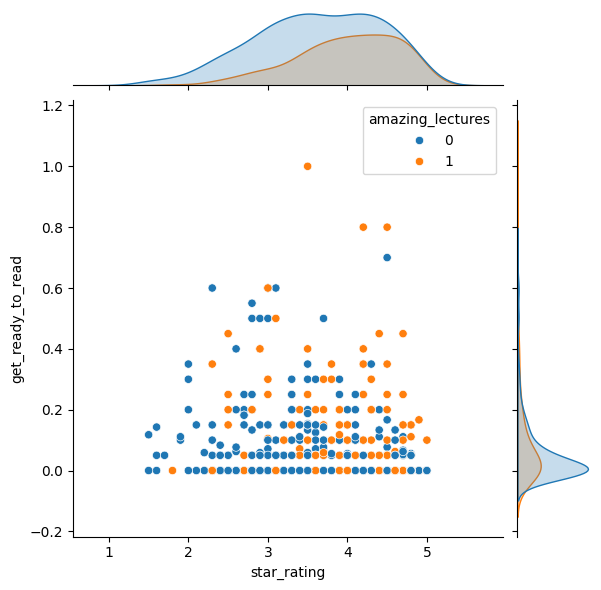

In [66]:
professor_data["amazing_lectures"] = professor_data["amazing_lectures"].apply(lambda x: 1 if x > 0 else 0)
sns.jointplot(data=professor_data, x="star_rating", y="get_ready_to_read", hue="amazing_lectures")

In [10]:
# pip installs for running locally

! pip install gensim
! pip install pandas
! pip install nltk
! pip install seaborn
! pip install matplotlib

     ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
      --------------------------------------- 0.0/1.5 MB 660.6 kB/s eta 0:00:03
     -- ------------------------------------- 0.1/1.5 MB 919.0 kB/s eta 0:00:02
     -------------------- ------------------- 0.8/1.5 MB 6.2 MB/s eta 0:00:01
     ---------------------------------------- 1.5/1.5 MB 8.7 MB/s eta 0:00:00
     ---------------------------------------- 0.0/42.0 kB ? eta -:--:--
     ---------------------------------------- 42.0/42.0 kB 2.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB 3.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/269.6 kB ? eta -:--:--
   --------------------------------------- 269.6/269.6 kB 17.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/97.9 kB ? eta -:--:--
   --------------